In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from datetime import datetime
import gc

# https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset?rvi=1
Data1_raw = pd.read_csv("./Data/Raw/Data1_raw.csv")

# https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
Data2_raw = pd.read_csv("./Data/Raw/Data2_raw.csv")

<font size=7><b>Section 1: Database Creation</b></font>

**Note to grader**: Thank you for looking at our submission! We hope that the detailed exploratory analysis and thorough data cleaning done in **Part 1.4**, **Part 3.3**, and **Part 3.4** of this notebook can be assessed under the rubric section "extraordinary extra features" and be considered for extra credit if deemed deserving. Thank you so much!

<br>

This notebook handles all of the following:
* Data cleaning and exploratory analysis of our two data sources `Data1_raw.csv` (https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset?rvi=1) and `Data2_raw.csv` (https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data).
* Entity resolution of entries in both data sources into the same logical schema.
* Breaking the large (~10GB combined) and redundant raw data into better designed tables according to the database's logical structure. Looking ahead to Section 2, these smaller tables (combined < 1GB) can then be imported into a MySQL database using the file `Section2_LoadIntoMySQL.sql`.

<br>

Notebook table of contents:
* **Part 0: The database schema.**
* **Part 1: Data cleaning and exploratory analysis for `Data1`.**
    * Part 1.1: Sneak peak at data.
    * Part 1.2: Dropping useless data.
    * Part 1.3: Dealing with missing values.
    * Part 1.4: Column-level cleaning and exploratory analysis.
* **Part 2: Decomposing `Data1` into database schema with entity resolution.**
    * Part 2.1: General observations.
    * Part 2.2: Decompose mega-table into databse schema.
    * Part 2.3: Check if decomposition was lossless.
    * Part 2.4: Column renaming.
* **Part 3: Data cleaning and exploratory analysis for `Data2`.**
    * Part 3.1: Sneak peak at data.
    * Part 3.2: Dropping useless data.
    * Part 3.3: Column-level cleaning.
    * Part 3.4: Exploratory analysis.
* **Part 4: Decomposing `Data2` into database schema with entity resolution.**
    * Part 4.1: Creating the *MMYT* relation
    * Part 4.2: Creating the *Car* relation
    * Part 4.3: Creating the *Dealer* relation
    * Part 4.4: Creating the *Listing* relation
* **Part 5: Merging `Data1` and `Data2` to build the final database.**
    * Part 5.1: Merge *Car*
    * Part 5.2: Merge *MMYT*
    * Part 5.3: Merge *Dealer*
    * Part 5.4: Merge *Listing*
    * Part 5.5: Export database files
* **Appendix A: Final processing function for `Data1`.**
* **Appendix B: Final processing function for `Data2`.**
* **Appendix C: Function to create all database tables and export to csv.**

# Part 0: The database schema

Our database schema is:
* Car(**vin**, *mmyt_id*, odometer, is_certified_preowned, has_accidents, transmission_type, exterior_color, horsepower, max_horsepower_at_rpm, max_torque_at_rpm, engine_type, engine_displacement, fuel_type, city_mpg, highway_mpg)
    * This relation represents a used car instance.
* MMYT(**mmyt_id**, make_name, model_name, production_year, trim_name, body_type, max_seats, fuel_tank_gallons, drivetrain, vehicle_length, vehicle_width, vehicle_height, wheelbase, mmyt_description)
    * This relation represents the make, model, year, and trim of a category of cars.
* Dealer(**dealer_id**, dealer_name, total_listings, avg_rating, location, zipcode, longitude, latitude, is_franchise_dealer)
    * This relationship represents a dealer selling used cars.
* Listing(**listing_id**, *vin*, *dealer_id*, price, listing_year, listing_month, listing_day, days_on_market)
    * This relation represents a sales listing that a dealer has posted for a specific used car.

(Primary keys are **bolded**, foreign keys are *italicized* and have the same name as the primary keys of the relations to which they refer.)

Both datasets, in their raw form, consists of a single mega-table. Parts 1 and 3 handle data cleaning, and parts 2 and 4 handle parsing the mega-table into the above schema.

Lastly, when building the database, we will check our functional dependencies and so primary key constraints in a simplified manner (might not be perfect but works for our purposes): we drop duplicates on column set $A$ and drop duplicates on column set $A \cup B$ (the function below takes in lists not sets since lists interface more seemlessly with pandas indexing, but same idea), if the size of the first resultant dataframe is the same as the second resultant dataframe, then $A \rightarrow B$.

In [2]:
def uniquely_determines(A, B, data):
    """Check if the columns in list A uniquely determines the columns in list B on data"""
    size_1 = data[set(A)].drop_duplicates().shape[0]
    size_2 = data[set(A+B)].drop_duplicates().shape[0]
    print(f"Uniques on A: {size_1}, uniques on A union B: {size_2}")
    return size_1 == size_2

# Part 1: Data cleaning and exploratory analysis for `Data1`

## Part 1.1: Sneak peak at data

In [3]:
Data1_raw

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000035,2GNAXJEV0J6261526,39.7 in,NaN,NaN,NaN,SUV / Crossover,NaN,Fairfield,26.0,NaN,...,A,Automatic,t72936,1.5T LT FWD,NaN,FWD,Front-Wheel Drive,107.3 in,72.6 in,2018
3000036,1GNERFKW0LJ225508,38.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Vallejo,18.0,NaN,...,A,Automatic,t85763,LS FWD,NaN,FWD,Front-Wheel Drive,120.9 in,78.6 in,2020
3000037,3FA6P0HD3GR134062,38.3 in,NaN,NaN,NaN,Sedan,NaN,Napa,NaN,NaN,...,A,6-Speed Automatic Overdrive,t57569,SE,NaN,FWD,Front-Wheel Drive,112.2 in,83.5 in,2016
3000038,SAJAJ4BNXHA968809,35 in,NaN,NaN,NaN,Sedan,NaN,Fairfield,30.0,NaN,...,A,Automatic,t65977,20d Premium AWD,NaN,AWD,All-Wheel Drive,111.6 in,81.7 in,2017


In [4]:
Data1_raw.columns

Index(['vin', 'back_legroom', 'bed', 'bed_height', 'bed_length', 'body_type',
       'cabin', 'city', 'city_fuel_economy', 'combine_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_certified', 'is_cpo', 'is_new', 'is_oemcpo', 'latitude', 'length',
       'listed_date', 'listing_color', 'listing_id', 'longitude',
       'main_picture_url', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'power', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'sp_name', 'theft_title',
       'torque', 'transmission', 'transmission_display', 'trimId', 'trim_name',
       'vehicle_damage_category', 'whe

Lots of columns, many of which seem to have redundant information and/or lots of NULLs, let's take a closer look.

## Part 1.2: Dropping useless data

### No valid entries

As shown by the code segment below, the columns `combine_fuel_economy`, `is_certified`, `vehicle_damage_category` only contain null values. This is likely an oversight by the data collectors.

In [5]:
Data1_raw[["combine_fuel_economy", "is_certified", "vehicle_damage_category"]].isnull().all()

combine_fuel_economy       True
is_certified               True
vehicle_damage_category    True
dtype: bool

Drop them!

In [6]:
Data1_raw = Data1_raw.drop(columns=["combine_fuel_economy", "is_certified", "vehicle_damage_category"])

### Redundant info

`engine_cylinders` has the exact same entries as `engine_type`:

In [7]:
(Data1_raw.engine_cylinders.dropna() == Data1_raw.engine_type.dropna()).all()

True

Drop `engine_cylinders`.

In [8]:
Data1_raw = Data1_raw.drop(columns=["engine_cylinders"])

`exterior_color` is just `listing_color` with more vehicle-specific detail that will bog down the modelling/prediction we plan to do once database is created:

In [9]:
Data1_raw.exterior_color.value_counts()

Black                                  162463
White                                  126560
Summit White                            96432
Silver                                  78908
Gray                                    77562
                                        ...  
Blue Dusk Clearcoat Metallic                1
Dark Performancesian Green Metallic         1
BRILLANT                                    1
WHITE MET                                   1
Cosmic                                      1
Name: exterior_color, Length: 28665, dtype: int64

Here we'll just drop `exterior_color`.

In [10]:
Data1_raw = Data1_raw.drop(columns=["exterior_color"])

Likewise, `transmission_display` is just `transmission` with more vehicle-specific detail that will bog down modelling -> here we'll just drop `transmission_display`.

In [11]:
Data1_raw = Data1_raw.drop(columns=["transmission_display"])

`is_cpo` (dealer certified pre-owned) heavily overlaps with `is_oemcpo` (manufacturer certified pre-owned) -> drop `is_cpo`.

In [12]:
Data1_raw = Data1_raw.drop(columns=["is_cpo"])

`wheel_system_display` is just a renaming of `wheel_system` -> drop `wheel_system_display`.

In [13]:
Data1_raw = Data1_raw.drop(columns=["wheel_system_display"])

### Overly specific/otherwise useless info

The following columns contain either overly specific info (too many categoies) or info that has little to no bearing on the vehicle price which we want to predict using the database:

`back_legroom`, `bed`, `bed_height`, `bed_length`, `cabin`, `description`, `fleet`, `frame_damaged`, `franchise_make`, `front_legroom`, `interior_color`, `isCab`, `is_new`, `main_picture_url`, `major_options`, `owner_count`, `salvage`, `savings_amount`, `theft_title`

We'll drop all of them.

In [14]:
Data1_raw = Data1_raw.drop(columns=["back_legroom", "bed", "bed_height", "bed_length",
                                    "cabin", "description", "fleet", "frame_damaged", "franchise_make",
                                    "front_legroom", "interior_color", "isCab", "is_new",
                                    "main_picture_url", "major_options", "owner_count",
                                    "salvage", "savings_amount", "theft_title"])

## Part 1.3: Dealing with missing values

Even after dropping the most egregious columns when it comes to NULL values, there are still a lot of NULLs in the remaining columns that can mean different things in different contexts. Let's go through them:

In [15]:
Data1_raw.isnull().sum()

vin                           0
body_type                 13543
city                          0
city_fuel_economy        491285
daysonmarket                  0
dealer_zip                    0
engine_displacement      172386
engine_type              100581
franchise_dealer              0
fuel_tank_volume         159269
fuel_type                 82724
has_accidents           1426595
height                   159269
highway_fuel_economy     491285
horsepower               172386
is_oemcpo               2864678
latitude                      0
length                   159269
listed_date                   0
listing_color                 0
listing_id                    0
longitude                     0
make_name                     0
maximum_seating          159269
mileage                  144387
model_name                    0
power                    481426
price                         0
seller_rating             40872
sp_id                        96
sp_name                       0
torque  

In the case of `has_accidents`, NULL values are actually important and should not be blindly discarded, since not reporting accidents can indeed often mean that minor damage occured. Let's impute a third value "Unreported" for missings in this variable:

In [16]:
Data1_raw["has_accidents"] = Data1_raw.has_accidents.fillna("Unreported")

Furthermore, NULLs in `is_oemcpo` (manufacturer certified pre-owned) are also meaningful (actually `is_oemcpo` only has True or NULL entries). The data was scrapped from a number of websites on which a tag will appear if the vehicle was certified and not otherwise: a missing value here is likely to mean that the car was not certified, as opposed to implying a truly unknown value. We can safely fill missings here with "False":

In [17]:
Data1_raw["is_oemcpo"] = Data1_raw.is_oemcpo.fillna("False")

Finally, `power`, `torque`, `city_fuel_economy`, and `highway_fuel_economy` all have a large number of missing values while not being critical variables. Simply dropping them would be to lose a lot of data over what is probably less important information. Therefore, we will fill NULLs in `power` and `torque` with "Unknown" and NULLs in `city_fuel_economy` and `highway_fuel_economy` with "-1":

In [18]:
Data1_raw["power"] = Data1_raw.power.fillna("Unknown")
Data1_raw["torque"] = Data1_raw.torque.fillna("Unknown")
Data1_raw["city_fuel_economy"] = Data1_raw.city_fuel_economy.fillna(-1)
Data1_raw["highway_fuel_economy"] = Data1_raw.highway_fuel_economy.fillna(-1)

As a last note, as evidence below, this data also occassionally uses "--" to repesent NULL values:

In [19]:
(Data1_raw == "--").sum()

vin                        0
body_type                  0
city                       0
city_fuel_economy          0
daysonmarket               0
dealer_zip                 0
engine_displacement        0
engine_type                0
franchise_dealer           0
fuel_tank_volume        1408
fuel_type                  0
has_accidents              0
height                   468
highway_fuel_economy       0
horsepower                 0
is_oemcpo                  0
latitude                   0
length                   457
listed_date                0
listing_color              0
listing_id                 0
longitude                  0
make_name                  0
maximum_seating          501
mileage                    0
model_name                 0
power                      0
price                      0
seller_rating              0
sp_id                      0
sp_name                    0
torque                     0
transmission               0
trimId                     0
trim_name     

Let's replace these with null values so they can dropped in the next step:

In [20]:
Data1_raw = Data1_raw.replace("--", np.nan)

Now that every meaningful NULL value has been handled, we can drop the rows with unmeaningful, actually missing values:

In [21]:
Data1_raw = Data1_raw.dropna()

## Part 1.4: Column-level cleaning and exploratory analysis

### Cleaning price

Let's begin with our intended target variable: price.

<Axes: xlabel='price', ylabel='Density'>

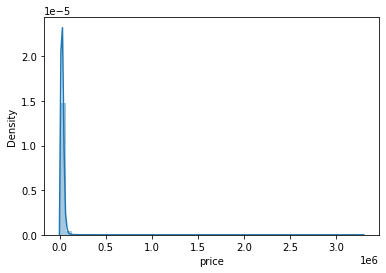

In [22]:
sns.distplot(Data1_raw.price)

There are some huge outliers! 3,000,000 is a lot to pay for a car... is this a mistake? Let's look at all cars above 1 million:

In [23]:
Data1_raw.loc[Data1_raw.price > 1000000, ["make_name", "model_name"]]

,make_name,model_name
28720,Ferrari,599 GTB Fiorano
174408,Ferrari,Enzo
179396,McLaren,P1
230048,Ford,Edge
582945,Lotus,Elise
908807,Bugatti,Veyron
1410578,Ferrari,Enzo
2056790,Porsche,918 Spyder
2114147,Chevrolet,Volt
2125636,Dodge,Grand Caravan


I'm not an expert on luxury cars... but these brands do seem kind of reasonable? In any case, whether the 3M is a mistake or not, taking our a few huge outliers is never a bad idea. For now, let's conservatively drop everything above 1M, which still leaves us a lot of very expensive cars!

In [24]:
Data1_raw = Data1_raw[Data1_raw.price < 1000000]

### Cleaning `mileage`

The car's odometer is usually one of most important factors in determining used car prices, let's take a look:

<Axes: xlabel='mileage', ylabel='Density'>

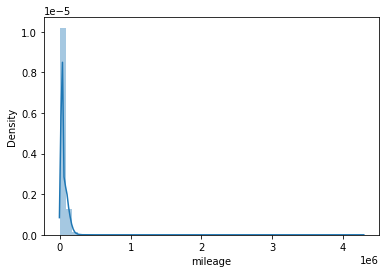

In [25]:
sns.distplot(Data1_raw.mileage)

4 million miles! What kind of car can go 4 million miles?! What kind of car can go 1 million miles?

In [26]:
Data1_raw.loc[Data1_raw.mileage > 1000000, ["price", "make_name", "model_name", "mileage"]]

,price,make_name,model_name,mileage
210044,50775.0,Chevrolet,Silverado 1500,4290461.0
1319359,45149.0,Ford,F-150,1225238.0
2072522,39523.0,Chevrolet,Silverado 1500,1111111.0
2072617,23620.0,Chevrolet,Equinox,1111111.0
2073566,41420.0,Chevrolet,Silverado 1500,1111111.0
2074186,41420.0,Chevrolet,Silverado 1500,1111111.0
2075306,45970.0,Cadillac,XT5,1111111.0


Yup, the Silverado is believable... still... 4 million miles? Crazy. Again, there are so few cars in this category I feel comfortable just dropping all of the 1M mile club members:

In [27]:
Data1_raw = Data1_raw[Data1_raw.mileage < 1000000]

### Cleaning `engine_type`

The column `engin_type` actually seems to include a lot of information about fuel type as well:

In [28]:
Data1_raw.engine_type.unique()

array(['I4', 'V6', 'V6 Diesel', 'I6', 'V8', 'H4', 'V8 Biodiesel',
       'V8 Flex Fuel Vehicle', 'V6 Flex Fuel Vehicle', 'I4 Hybrid',
       'V6 Hybrid', 'I3', 'I5', 'I4 Diesel', 'I4 Flex Fuel Vehicle',
       'I6 Diesel', 'R2', 'W12', 'V10', 'V12', 'V8 Diesel',
       'V6 Biodiesel', 'H6', 'I2', 'W12 Flex Fuel Vehicle',
       'I5 Biodiesel', 'V8 Hybrid', 'H4 Hybrid',
       'V8 Compressed Natural Gas', 'I6 Hybrid', 'W8',
       'I4 Compressed Natural Gas', 'I5 Diesel', 'V10 Diesel',
       'V8 Propane', 'I3 Hybrid', 'V6 Compressed Natural Gas', 'W16'],
      dtype=object)

On the other hand, we do have a dedicated column for `fuel_type`...

In [29]:
Data1_raw.fuel_type.value_counts()

Gasoline                  2317280
Flex Fuel Vehicle          132624
Hybrid                      66359
Diesel                      37054
Biodiesel                   20968
Compressed Natural Gas        133
Propane                         4
Name: fuel_type, dtype: int64

Now the question is: does the fuel type indicated in `engine_type` match the corresponding entries in `fuel_type`? Let's take out the actual engine string from `engine_type`:

In [30]:
Data1_raw.engine_type.str.split().str[1:].str.join(" ").value_counts()

                          2317280
Flex Fuel Vehicle          132624
Hybrid                      66359
Diesel                      37054
Biodiesel                   20968
Compressed Natural Gas        133
Propane                         4
Name: engine_type, dtype: int64

The numbers seem to match. Furthermore, it seems that if no fuel in particular was specified in `engine_type`, the actual type of fuel seems to be gasoline. Let's replace the blank entries with gasoline and see if the columns match:

In [31]:
(Data1_raw.engine_type.str.split().str[1:].str.join(" ").replace({"": "Gasoline"}) == Data1_raw.fuel_type).all()

True

Indeed every single value matches! This means we can safely take only the engine type string for `engine_type` and discard the rest of that variable, since the info is already in `fuel_type`.

In [32]:
Data1_raw["engine_type"] = Data1_raw.engine_type.str.split().str[0]

### Cleaning `fuel_tank_volume`

One would expect `fuel_tank_volume` to be just a number, except this dataset also included the units:

In [33]:
Data1_raw.fuel_tank_volume.value_counts()

26 gal      180132
13.2 gal    140356
18.5 gal    135805
14 gal      126698
14.5 gal     91693
             ...  
29.1 gal         2
63 gal           2
25.5 gal         2
40.7 gal         1
26.3 gal         1
Name: fuel_tank_volume, Length: 180, dtype: int64

Are all the entries in gallons?

In [34]:
(Data1_raw.fuel_tank_volume.str.split().str[1] == "gal").all()

True

Yup, that means we can just take first token and convert it to a float:

In [35]:
Data1_raw["fuel_tank_volume"] = Data1_raw.fuel_tank_volume.str.split().str[0].astype(float)

Let's take a look:

<Axes: xlabel='fuel_tank_volume', ylabel='Density'>

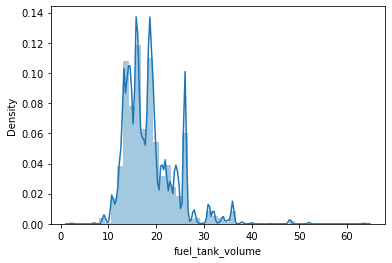

In [36]:
sns.distplot(Data1_raw.fuel_tank_volume)

Certainly a lot of large fuel tanks!

### Cleaning `height`, `width`, and `length`

`height`, `width`, and `length` behave just like `fuel_tank_volume`, with useless units (inches in this case) making a numeric variable a categorical:

In [37]:
(Data1_raw.height.str.split().str[1] == "in").all()

True

In [38]:
(Data1_raw.width.str.split().str[1] == "in").all()

True

In [39]:
(Data1_raw.length.str.split().str[1] == "in").all()

True

Same treatment as `fuel_tank_volume`:

In [40]:
Data1_raw["height"] = Data1_raw.height.str.split().str[0].astype(float)
Data1_raw["width"] = Data1_raw.width.str.split().str[0].astype(float)
Data1_raw["length"] = Data1_raw.length.str.split().str[0].astype(float)

Just for fun, let's take a look at these dimensions too:

<Axes: xlabel='height', ylabel='Density'>

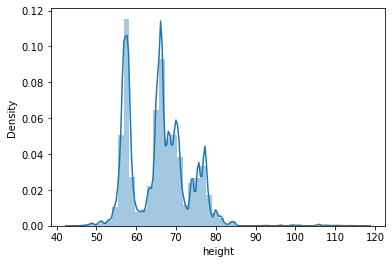

In [41]:
sns.distplot(Data1_raw.height)

<Axes: xlabel='width', ylabel='Density'>

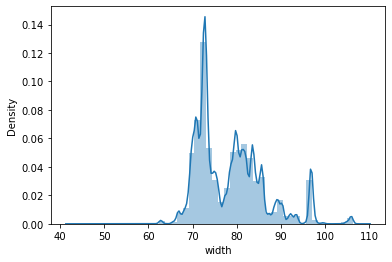

In [42]:
sns.distplot(Data1_raw.width)

<Axes: xlabel='length', ylabel='Density'>

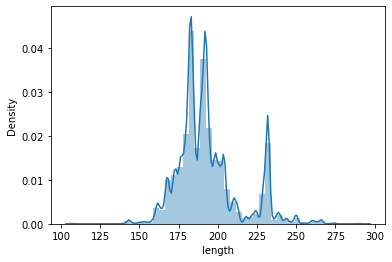

In [43]:
sns.distplot(Data1_raw.length)

This makes sense! Each mode in each plot essentially maps to one/a few vehicle categories, with smaller vehicles (like sedans, hatchbacks, coupes, etc.) being usually the first mode and larger trucks populating the higher modes.

### Cleaning `maximum_seating`

Once again, we have another `fuel_tank_volume` situation with `maximum_seating`:

In [44]:
(Data1_raw.maximum_seating.str.split().str[1] == "seats").all()

True

Same treatment as before:

In [45]:
Data1_raw["maximum_seating"] = Data1_raw.maximum_seating.str.split().str[0].astype(float)

A brief look:

<Axes: xlabel='maximum_seating', ylabel='Density'>

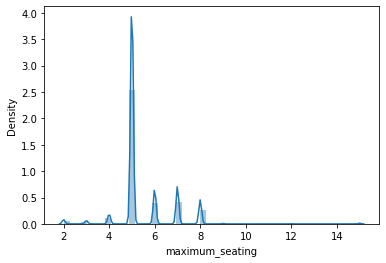

In [46]:
sns.distplot(Data1_raw.maximum_seating)

Yep, 5-seaters are most common.

### Cleaning `wheelbase`

Our final useless string-to-float conversion is `wheelbase`:

In [47]:
(Data1_raw.wheelbase.str.split().str[1] == "in").all()

True

In [48]:
Data1_raw["wheelbase"] = Data1_raw.wheelbase.str.split().str[0].astype(float)

A brief look:

<Axes: xlabel='wheelbase', ylabel='Density'>

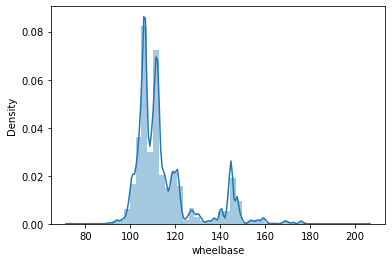

In [49]:
sns.distplot(Data1_raw.wheelbase)

Again, same mulitmodal stituation as the dimension measurements, expected!

### Cleaning `listed_date`

As with all date variables, we have to be a bit careful with `listed_date`.

In [50]:
Data1_raw.listed_date.head(5)

0    2019-04-06
1    2020-02-15
3    2020-02-26
4    2020-04-25
5    2020-01-11
Name: listed_date, dtype: object

It seems to be in yyyy-mm-dd format, let's split it out into three columns:

In [51]:
Data1_raw["listing_year"] = Data1_raw.listed_date.str[0:4].astype(int)
Data1_raw["listing_month"] = Data1_raw.listed_date.str[5:7].astype(int)
Data1_raw["listing_day"] = Data1_raw.listed_date.str[8:10].astype(int)
Data1_raw = Data1_raw.drop(columns=["listed_date"])

As always, let's take a look:

<Axes: xlabel='listing_day', ylabel='Density'>

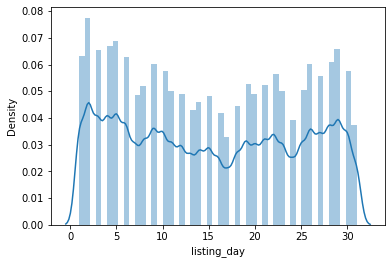

In [52]:
sns.distplot(Data1_raw.listing_day)

As expected, no significant difference in listing amounts throughout the month. The gaps in the plot are just due to seaborn's automatic binning which I'm too lazy to change -> there are indeed values for every single day.

<Axes: xlabel='listing_month', ylabel='Density'>

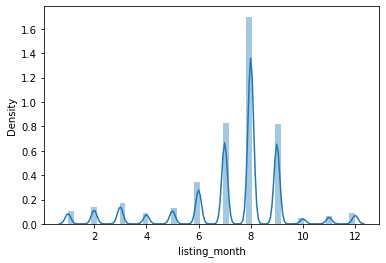

In [53]:
sns.distplot(Data1_raw.listing_month)

<Axes: xlabel='listing_year', ylabel='Density'>

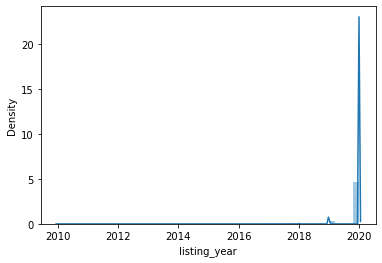

In [54]:
sns.distplot(Data1_raw.listing_year)

Haha it seems like there's a car that was listed in 2010 and either no one every bought it or it was never taken off the listing site, is this a mistake?

In [55]:
Data1_raw[Data1_raw.listing_year == 2010].daysonmarket

719796    3573
Name: daysonmarket, dtype: int64

No mistake... 3500+ days is indeed around 10 years from 2020, when this data was scraped.

### Cleaning `dealer_zip`

`dealer_zip` is a zipcode and should be an int, however:

In [56]:
Data1_raw.dealer_zip.dtype

dtype('O')

This is because there are zipcodes like "96740-1631". For these zipcodes, we'll just keep the first part (we have the longitude and latitude anyways):

In [57]:
Data1_raw["dealer_zip"] = Data1_raw.dealer_zip.astype(str).str.split("-").str[0].astype(int)

### Padding, `sp_id`, `listing_id`, and `trimId`

`sp_id` refers to the ID of a dealership while `listing_id` refers to the ID of a particular listing for a vehicle. Both currently as numeric types:

In [58]:
Data1_raw.sp_id

0          370599.0
1          389227.0
3          389227.0
4          389227.0
5          389227.0
             ...   
3000034     55297.0
3000035    341247.0
3000036    310674.0
3000038    341247.0
3000039     64910.0
Name: sp_id, Length: 2574422, dtype: float64

In [59]:
Data1_raw.listing_id

0          237132766
1          265946296
3          266911050
4          270957414
5          262940541
             ...    
3000034    274134037
3000035    280498781
3000036    269431681
3000038    280923167
3000039    280345818
Name: listing_id, Length: 2574422, dtype: int64

However, the other 2 ID variables, `vin` and `trimID`, come as strings with distinct identifying characteristics. For consistency's sake and ease of identification, let's pad out `sp_id` and `listing_id` and prefix them with "D" for dealer and "L" for listing, respectively:

In [60]:
# NOTE: Data1_raw.sp_id.astype(int).astype(str).str.len().max() == 6
# NOTE: Data1_raw.listing_id.astype(str).str.len().max() == 9
Data1_raw["sp_id"] = "D" + Data1_raw.sp_id.astype(int).astype(str).str.zfill(7) # pad one more zero in case more added later!
Data1_raw["listing_id"] = "L" + Data1_raw.listing_id.astype(str).str.zfill(10) # pad one more zero in case more added later!

While we're at it, let's pad out `trimId` and replace the lowercase "t" with the uppercase "MMYT" for Make-Model-Year-Trim (more on why later):

In [61]:
# NOTE: Data1_raw.trimId.str[1:].str.len().max() == 5
Data1_raw["trimId"] = "MMYT" + Data1_raw.trimId.str[1:].str.zfill(6) # pad one more zero in case more added later!

### Fixing `trim_name`

We would expect `trimId` to uniquely determine `trim_name`, except it doesn't...

In [62]:
Data1_raw[["trimId", "trim_name"]].groupby("trimId").nunique().query("trim_name > 1")

,trim_name
trimId,
MMYT001743,2
MMYT001841,2
MMYT001951,2
MMYT001970,2
MMYT002143,2
...,...
MMYT088991,2
MMYT089640,2
MMYT090309,2


That said, all of these differences are non-meaningful in the long run, take a few examples:

In [63]:
Data1_raw.loc[Data1_raw.trimId == "MMYT001743", ["make_name", "model_name", "trim_name"]].drop_duplicates()

,make_name,model_name,trim_name
26751,Chevrolet,Trailblazer,LS 4WD
649638,Chevrolet,Trailblazer,LT 4WD


Chevy's LS and LT has never been particularly crystal clear and oftentimes can denote the same trim if one looks across production years or special optioning. Another example:

In [64]:
Data1_raw.loc[Data1_raw.trimId == "MMYT089640", ["make_name", "model_name", "trim_name"]].drop_duplicates()

,make_name,model_name,trim_name
1781100,Honda,Civic,Si Coupe FWD with Summer Tires
2257149,Honda,Civic,Si Coupe FWD


For our purposes, we won't be too concerned about summer tires... One more example:

In [65]:
Data1_raw.loc[Data1_raw.trimId == "MMYT076529", ["make_name", "model_name", "trim_name"]].drop_duplicates()

,make_name,model_name,trim_name
21434,Nissan,Rogue,2017.5 SV FWD
839975,Nissan,Rogue,SV FWD


Again, no significant difference. For now, I will simply use pandas magic to replace all the differing trim names with whichever one has the least character count, since the shortest character count is probably the one that is the most generic:

In [66]:
problem_trimIds = Data1_raw[["trimId", "trim_name"]].groupby("trimId").nunique().query("trim_name > 1").index
replacement_trim_names = Data1_raw.loc[Data1_raw.trimId.isin(problem_trimIds), ["trimId", "trim_name"]]
replacement_trim_names["str_length"] = replacement_trim_names.trim_name.str.len()
replacement_trim_names = replacement_trim_names.sort_values("str_length").drop_duplicates("trimId")[["trimId", "trim_name"]]
Data1_raw = Data1_raw.merge(right=replacement_trim_names, how="left", on="trimId", suffixes=("", "_replacement"))
Data1_raw.loc[Data1_raw.trimId.isin(problem_trimIds), "trim_name"] = Data1_raw.loc[Data1_raw.trimId.isin(problem_trimIds), "trim_name_replacement"]
Data1_raw = Data1_raw.drop(columns=["trim_name_replacement"])

Now `trimId` uniquely determines `trim_name`!

### A bit more cleaning to make `trimId` better

`trimId` is pretty powerful, except that there are a couple mistaken entires that mess up what it can and cannot uniquely determine. Take `trimId = MMYT047624` for example:

In [67]:
Data1_raw.loc[Data1_raw.trimId == "MMYT047624", ["trimId", "make_name", "model_name", "trim_name", "year", "body_type"]]

,trimId,make_name,model_name,trim_name,year,body_type
129215,MMYT047624,Toyota,Prius Plug-In,Base,2012,Sedan
149803,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
172121,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
196247,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
239168,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
1434532,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
1694471,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
2256008,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
2423967,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback
2529964,MMYT047624,Toyota,Prius Plug-In,Base,2012,Hatchback


Although the distinction between sedans and hatchbacks is blurry, I'm pretty sure no Prius has ever been marketed as a sedan since 2003... that must have been a mistake on the dealer's side. In other words, `trimId` should be able to uniquely determine `body_type`, but some misentries prevent it from doing so. Other columns in which this happens are `maximum_seating` and `height`. For now, instead of doing add-hoc changes one-by-one, I will just remove the `trimId`s for which this happens (~20 total out of ~37k), since they probably represent on-the-edge cases that are easy to mess up (hatchbacks vs. sedans, for example):

In [68]:
more_problem_trimIds = set(Data1_raw[["trimId", "body_type"]].groupby("trimId").nunique().query("body_type > 1").index).union(
                       set(Data1_raw[["trimId", "maximum_seating"]].groupby("trimId").nunique().query("maximum_seating > 1").index).union(
                       set(Data1_raw[["trimId", "height"]].groupby("trimId").nunique().query("height > 1").index)))
Data1_raw = Data1_raw[~Data1_raw.trimId.isin(more_problem_trimIds)]

### A bit more cleaning to make `sp_id` better

Just like `trimId`, there are a few (<10) problematic dealerships that have the same ID but different values for `sp_name`, `city`, `dealer_zip`, `longitude`, `latitude`, and `franchise_dealer`. We'll remove them as their entries do not logically make sense:

In [69]:
problem_sp_ids = set(Data1_raw[["sp_id", "sp_name"]].groupby("sp_id").nunique().query("sp_name > 1").index).union(
                 set(Data1_raw[["sp_id", "city"]].groupby("sp_id").nunique().query("city > 1").index).union(
                 set(Data1_raw[["sp_id", "dealer_zip"]].groupby("sp_id").nunique().query("dealer_zip > 1").index).union(
                 set(Data1_raw[["sp_id", "longitude"]].groupby("sp_id").nunique().query("longitude > 1").index).union(
                 set(Data1_raw[["sp_id", "latitude"]].groupby("sp_id").nunique().query("latitude > 1").index).union(
                 set(Data1_raw[["sp_id", "franchise_dealer"]].groupby("sp_id").nunique().query("franchise_dealer > 1").index))))))
Data1_raw = Data1_raw[~Data1_raw.sp_id.isin(problem_sp_ids)]

### Dealer aggregate statistics

Let's get some aggregrate statistics for every `sp_id`! For now, let us do:
* `avg_rating`: average rating of the dealer over the entire dataset
* `total_listings`: total number of vehicles this dealer has listed

In [70]:
avg_rating_df = Data1_raw[["sp_id", "seller_rating"]].groupby("sp_id").mean().reset_index().rename({"seller_rating": "avg_rating"},axis=1)
Data1_raw = Data1_raw.merge(right=avg_rating_df, how="left", on="sp_id")
Data1_raw = Data1_raw.drop(columns=["seller_rating"])
total_listings_df = Data1_raw.groupby("sp_id").size().rename("total_listings").reset_index()
Data1_raw = Data1_raw.merge(right=total_listings_df, how="left", on="sp_id")

### Removing semicolons

We will be using semicolons as csv deliminators (since commas appear way too much!), so we need to make sure no strings contain it:

In [71]:
for column in Data1_raw.columns:
    if Data1_raw[column].dtype == "O":
        print(f"Column {column} has {Data1_raw[column].astype(str).str.contains(';').sum()} values with ';'.")

Column vin has 0 values with ';'.
Column body_type has 0 values with ';'.
Column city has 0 values with ';'.
Column engine_type has 0 values with ';'.
Column fuel_type has 0 values with ';'.
Column has_accidents has 0 values with ';'.
Column is_oemcpo has 0 values with ';'.
Column listing_color has 0 values with ';'.
Column listing_id has 0 values with ';'.
Column make_name has 0 values with ';'.
Column model_name has 0 values with ';'.
Column power has 0 values with ';'.
Column sp_id has 0 values with ';'.
Column sp_name has 13 values with ';'.
Column torque has 0 values with ';'.
Column transmission has 0 values with ';'.
Column trimId has 0 values with ';'.
Column trim_name has 0 values with ';'.
Column wheel_system has 0 values with ';'.


Let's just take the part before the semicolon for simplicity:

In [72]:
semicolon_mask = Data1_raw.sp_name.str.contains(";")
Data1_raw.loc[semicolon_mask, "sp_name"] = Data1_raw.loc[semicolon_mask, "sp_name"].str.split(";").str[0]

### A note about makes and models

Note that `make_name` does not unique determine `model_name`! More than one make can make cars with the same model name (the cars are different, obviously):

In [73]:
Data1_raw[["model_name", "make_name"]].groupby("model_name").nunique().reset_index().query("make_name > 1")

,model_name,make_name
205,Cabriolet,2
292,Dakota,2
443,GT,2
534,LS,2
642,NX,2
647,Neon,2
682,Pickup,2
691,Prizm,2
697,Prowler,2
897,Sprinter Cargo,2


Here's an example:

In [74]:
Data1_raw.loc[Data1_raw.model_name=="Cabriolet", "make_name"].drop_duplicates()

640959           Audi
1253745    Volkswagen
Name: make_name, dtype: object

# Part 2: Decomposing `Data1` into database schema with entity resolution

## Part 2.1: General observations

### Are `vin` and `listing_id` are candidate keys for whole dataset?

First let's confirm that `listing_id` is indeed a candidate key for the whole dataset:

In [75]:
uniquely_determines(["listing_id"],list(Data1_raw.columns),Data1_raw)

Uniques on A: 2565033, uniques on A union B: 2565033


True

Great! Is there one listing per vehicle?

In [76]:
uniquely_determines(["vin"],["listing_id"],Data1_raw)

Uniques on A: 2565033, uniques on A union B: 2565033


True

In fact, `vin` and `listing_id` are one-to-one (each listing only has one vehicle):

In [77]:
uniquely_determines(["listing_id"],["vin"],Data1_raw)

Uniques on A: 2565033, uniques on A union B: 2565033


True

### What does `trimId` entail?

A further thought: what attributes are intrinsic to a trim level, and what are instrinsic to a specific vehicle? For example, does trim level uniquely determine `horsepower`?

In [78]:
uniquely_determines(["trimId"],["horsepower"],Data1_raw)

Uniques on A: 36964, uniques on A union B: 40785


False

It doesn't! This makes a lot of sense since not only can cars of the same trim come with differently tuned engines, previous owners might end up modifying their engines too! Depending on the engine, even some very simple mods can yield significant improvements to horsepower! We can see this by observing that even a make-model-trim-year tuple does not uniquely determine `horsepower`:

In [79]:
uniquely_determines(["make_name", "model_name", "trim_name", "year"],["horsepower"],Data1_raw)

Uniques on A: 36563, uniques on A union B: 40353


False

However, `trimId` does uniquely determine make and model as expected:

In [80]:
uniquely_determines(["trimId"],["make_name", "model_name"],Data1_raw)

Uniques on A: 36964, uniques on A union B: 36964


True

Interestingly, it also uniquely determines `year`:

In [81]:
uniquely_determines(["trimId"],["year"],Data1_raw)

Uniques on A: 36964, uniques on A union B: 36964


True

This means that the variable `trimId` can actually be used as an ID for a whole Make-Model-Trim-Year!

## Part 2.2: Decompose mega-table into databse schema

All in all, here is the database schema (the columns will be renamed later to produce the final schema):
* Car(**vin**, *trimId*, mileage, is_oemcpo, has_accidents, transmission, listing_color, horsepower, power, torque, engine_type, engine_displacement, fuel_type, city_fuel_economy, highway_fuel_economy)
* MMYT(**trimId**, make_name, model_name, year, trim_name, body_type, maximum_seating, fuel_tank_volume, wheel_system, length, width, height, wheelbase, mmyt_description)
* Dealer(**sp_id**, sp_name, total_listings, avg_rating, city, dealer_zip, longitude, latitude, franchise_dealer)
* Listing(**listing_id**, *vin*, *sp_id*, price, listing_year, listing_month, listing_day, daysonmarket)

(Primary keys are **bolded**, foreign keys are *italicized* and have the same name as the primary keys of the relations to which they refer.)

In [82]:
car_cols = ["vin", "trimId", "mileage", "is_oemcpo", "has_accidents", "transmission",
            "listing_color", "horsepower", "power", "torque", "engine_type",
            "engine_displacement", "fuel_type", "city_fuel_economy", "highway_fuel_economy"]
mmyt_cols = ["trimId", "make_name", "model_name", "year", "trim_name",
             "body_type", "maximum_seating", "fuel_tank_volume", "wheel_system",
             "length", "width", "height", "wheelbase"]
dealer_cols = ["sp_id", "sp_name", "total_listings", "avg_rating", "city",
               "dealer_zip", "longitude", "latitude", "franchise_dealer"]
listing_cols = ["listing_id", "vin", "sp_id", "price", "listing_year", "listing_month",
                "listing_day", "daysonmarket"]

Let's confirm once again that the primary key constraints are met:

In [83]:
uniquely_determines(["vin"],car_cols,Data1_raw)

Uniques on A: 2565033, uniques on A union B: 2565033


True

In [84]:
uniquely_determines(["trimId"],mmyt_cols,Data1_raw)

Uniques on A: 36964, uniques on A union B: 36964


True

In [85]:
uniquely_determines(["sp_id"],dealer_cols,Data1_raw)

Uniques on A: 25564, uniques on A union B: 25564


True

In [86]:
uniquely_determines(["listing_id"],listing_cols,Data1_raw)

Uniques on A: 2565033, uniques on A union B: 2565033


True

Everything works, now let's split:

In [87]:
Data1_cars = Data1_raw[car_cols].drop_duplicates()
Data1_mmyts = Data1_raw[mmyt_cols].drop_duplicates()
Data1_mmyts["mmyt_description"] = (Data1_mmyts.year.astype(str) # add a column to interface with Data2 better
                                   + " " + Data1_mmyts.make_name
                                   + " " + Data1_mmyts.model_name
                                   + " " + Data1_mmyts.trim_name)
Data1_dealers = Data1_raw[dealer_cols].drop_duplicates()
Data1_listings = Data1_raw[listing_cols].drop_duplicates()

## Part 2.3: Check if decomposition was lossless

This decomposition should be lossless, is it? As a final check, let's make extra sure that, if we merge the splitted relations, we get the original:

In [88]:
merged = Data1_listings.merge(Data1_cars.merge(Data1_mmyts.drop("mmyt_description", axis=1), on="trimId"), on="vin").merge(Data1_dealers, on="sp_id")[Data1_raw.columns].sort_values("vin").reset_index(drop=True)
orig_sorted = Data1_raw.drop_duplicates().sort_values("vin").reset_index(drop=True)
(merged == orig_sorted).all().all()

True

Yep, exactly the same!

## Part 2.4: Column renaming

The columns names are a bit messy, let's rename some of them for clarity:

In [89]:
Data1_cars.rename(columns= {
    "trimId":"mmyt_id",
    "mileage":"odometer",
    "is_oemcpo":"is_certified_preowned",
    "transmission":"transmission_type",
    "listing_color":"exterior_color",
    "power":"max_horsepower_at_rpm",
    "torque":"max_torque_at_rpm",
    "city_fuel_economy":"city_mpg",
    "highway_fuel_economy":"highway_mpg"
}, inplace=True)
Data1_mmyts.rename(columns= {
    "trimId":"mmyt_id",
    "year":"production_year",
    "maximum_seating":"max_seats",
    "fuel_tank_volume":"fuel_tank_gallons",
    "length":"vehicle_length",
    "width":"vehicle_width",
    "height":"vehicle_height",
    "wheel_system":"drivetrain"
}, inplace=True)
Data1_dealers.rename(columns= {
    "sp_id":"dealer_id",
    "sp_name":"dealer_name",
    "city":"location",
    "dealer_zip":"zipcode",
    "franchise_dealer":"is_franchise_dealer"
}, inplace=True)
Data1_dealers["is_franchise_dealer"] = Data1_dealers.is_franchise_dealer.astype(str)
Data1_listings.rename(columns= {
    "sp_id":"dealer_id",
    "daysonmarket":"days_on_market"
}, inplace=True)

Print out some per-column dtype stats for easy loading into MySQL:

In [90]:
def print_table_stats(table):
    for column in table.columns:
        print(f"{column} has dtype {table[column].dtype}")
        if table[column].dtype == "O":
            print(f"{column} has max char length {table[column].str.len().max()}")
        print("")

In [91]:
print_table_stats(Data1_cars)

vin has dtype object
vin has max char length 17

mmyt_id has dtype object
mmyt_id has max char length 10

odometer has dtype float64

is_certified_preowned has dtype object
is_certified_preowned has max char length 5.0

has_accidents has dtype object
has_accidents has max char length 10.0

transmission_type has dtype object
transmission_type has max char length 11

exterior_color has dtype object
exterior_color has max char length 7

horsepower has dtype float64

max_horsepower_at_rpm has dtype object
max_horsepower_at_rpm has max char length 20

max_torque_at_rpm has dtype object
max_torque_at_rpm has max char length 21

engine_type has dtype object
engine_type has max char length 3

engine_displacement has dtype float64

fuel_type has dtype object
fuel_type has max char length 22

city_mpg has dtype float64

highway_mpg has dtype float64



In [92]:
print_table_stats(Data1_mmyts)

mmyt_id has dtype object
mmyt_id has max char length 10

make_name has dtype object
make_name has max char length 13

model_name has dtype object
model_name has max char length 26

production_year has dtype int64

trim_name has dtype object
trim_name has max char length 99

body_type has dtype object
body_type has max char length 15

max_seats has dtype float64

fuel_tank_gallons has dtype float64

drivetrain has dtype object
drivetrain has max char length 3

vehicle_length has dtype float64

vehicle_width has dtype float64

vehicle_height has dtype float64

wheelbase has dtype float64

mmyt_description has dtype object
mmyt_description has max char length 123



In [93]:
print_table_stats(Data1_dealers)

dealer_id has dtype object
dealer_id has max char length 8

dealer_name has dtype object
dealer_name has max char length 81

total_listings has dtype int64

avg_rating has dtype float64

location has dtype object
location has max char length 29

zipcode has dtype int64

longitude has dtype float64

latitude has dtype float64

is_franchise_dealer has dtype object
is_franchise_dealer has max char length 5



In [94]:
print_table_stats(Data1_listings)

listing_id has dtype object
listing_id has max char length 11

vin has dtype object
vin has max char length 17

dealer_id has dtype object
dealer_id has max char length 8

price has dtype float64

listing_year has dtype int64

listing_month has dtype int64

listing_day has dtype int64

days_on_market has dtype int64



# Part 3: Data cleaning and exploratory analysis for `Data2`

## Part 3.1: Sneak peak at data

In [95]:
Data2_raw

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,...,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600


In [96]:
Data2_raw.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

## Part 3.2: Dropping useless data.

### County

The Kaggle page mentioned `county` is useless:

In [97]:
Data2_raw.county.isnull().all()

True

Yep, useless.

In [98]:
Data2_raw = Data2_raw.drop("county", axis=1)

### Url's

We won't need `url`, `region_url`, or `image_url`, so we don't have to include them.

In [99]:
Data2_raw = Data2_raw.drop(["url", "region_url", "image_url"], axis=1)

### Description

In [100]:
Data2_raw.description.str.len().max()

28832.0

`description` has some very, very long strings and isn't useful for our purposes. Additionally, commas in its entries might mess up MySQL csv parser, so throw it out too.

In [101]:
Data2_raw = Data2_raw.drop("description", axis=1)

### Null values

Finally, we need to drop the null values in the column `VIN`, since this column will be the primary key for the *Car* relation:

In [102]:
Data2_raw = Data2_raw[Data2_raw["VIN"].notna()]

## Part 3.3: Column-level cleaning.

### More on VIN

As stated before, `VIN` is highly important and should always be 17 digits, is that the case in this dataset?

In [103]:
Data2_raw[Data2_raw.VIN.str.len() != 17].VIN

338       11402312009097
1016          0906419252
1684       116356W169501
1698          7275856000
2524          B1DL120963
               ...      
425059      31847S147227
425300     1Z37L6S418690
426339       CR315045444
426373     CCL449J162701
426376     CCL449F505274
Name: VIN, Length: 1318, dtype: object

Nope... don't know what's going on with these VIN's that don't any sense. There are even a couple `VIN` entries with only 1 digit:

In [104]:
Data2_raw[Data2_raw.VIN.str.len() == 1].VIN

25010    C
27561    C
Name: VIN, dtype: object

All these entries are clearly erroneous, we should remove them:

In [105]:
Data2_raw = Data2_raw[Data2_raw.VIN.str.len() == 17]

### Deleting price outliers

<Axes: xlabel='price', ylabel='Density'>

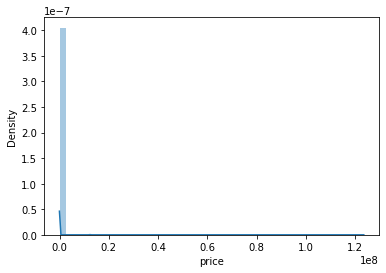

In [106]:
sns.distplot(Data2_raw.price)

There is/are some crazy outliers! Let's see what they are:

In [107]:
Data2_raw.nlargest(3, "price")

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
193736,7315524207,ann arbor,123456789,2015.0,chevrolet,cruze,like new,NaN,gas,64181.0,...,automatic,1G1PC5SB0F7246637,fwd,compact,sedan,red,mi,41.3815,-83.6507,2021-05-01T17:44:14-0400
286323,7316737760,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,...,automatic,00000000000000000,4wd,full-size,truck,black,oh,40.8465,-81.4408,2021-05-04T11:31:57-0400
286324,7316737396,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,...,automatic,00000000000000000,4wd,full-size,truck,black,oh,40.8465,-81.4408,2021-05-04T11:31:26-0400


There is no way a Chevy Cruze costs 100 million... there has to be some error. Indeed, in these cases, the price is just 1 sequentially entered until 9... Let's check the manufacturers of all cars greater than 300k:

In [108]:
Data2_raw[Data2_raw.price > 300000].manufacturer.value_counts()

chevrolet        7
ferrari          3
porsche          3
mercedes-benz    1
dodge            1
lincoln          1
Name: manufacturer, dtype: int64

With the exception of ferrari and porsche, there is no way these brands have used cars > 300k...  

For now, let's just drop everything greater than 300k and risk losing a few non-error luxury cars (seems like there are only 6 of those so we're good).

In [109]:
Data2_raw = Data2_raw[Data2_raw.price < 300000]

Now check the price distribution again:

<Axes: xlabel='price', ylabel='Density'>

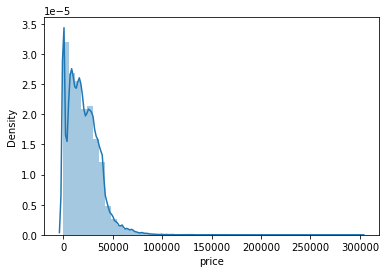

In [110]:
sns.distplot(Data2_raw.price)

Much more reasonable!

### Deleting free cars

That said, there seems to be some cars with price 0:

In [111]:
Data2_raw[Data2_raw.price <= 0].shape[0]

23936

That's a good amount... I'm guessing the price was missing or otherwise not found, since I doubt there are almost 33k free cars floating around (can I have one?). For now, let's just drop them:

In [112]:
Data2_raw = Data2_raw[Data2_raw.price > 0]

### Odometer

The odometer value tends to be one of the most important determiners in used car prices, let's take a look:

<Axes: xlabel='odometer', ylabel='Density'>

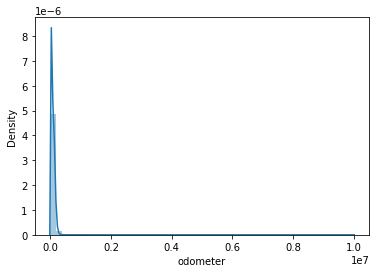

In [113]:
sns.distplot(Data2_raw.odometer)

Once again, some crazy values...

In [114]:
Data2_raw.nlargest(3, "odometer")

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
328533,7311553545,erie,600,1981.0,ford,f-150,fair,8 cylinders,gas,9999999.0,...,manual,1FTPW14545FA67066,rwd,full-size,truck,blue,pa,42.200800,-79.833200,2021-04-23T16:30:05-0400
355243,7311420685,knoxville,2650,1999.0,buick,regal gse,good,6 cylinders,gas,9999999.0,...,automatic,2G4WF5217X1621015,fwd,NaN,sedan,black,tn,35.755793,-83.931657,2021-04-23T12:58:50-0400
119725,7313089821,treasure coast,1000,1992.0,ford,f150 longbed,salvage,6 cylinders,gas,3000000.0,...,manual,1FTDF15Y0NNA64148,rwd,full-size,truck,green,fl,27.288900,-80.298000,2021-04-26T18:59:16-0400


Most older odometers cap at 999,999, so I doubt these values are correct.

For now, let's just drop everything with more than a million miles, since anything even remotely close to that number would be very, very rare indeed.

<Axes: xlabel='odometer', ylabel='Density'>

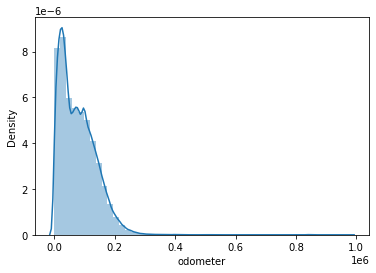

In [115]:
Data2_raw = Data2_raw[Data2_raw.odometer < 999999]
sns.distplot(Data2_raw.odometer)

### Split out date

In [116]:
Data2_raw.posting_date

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
32        2021-05-03T13:41:25-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 239394, dtype: object

We don't care about time, so just keep date: but is it yyyy-mm-dd or yyyy-dd-mm?

In [117]:
Data2_raw.posting_date.str[5:7].astype(int).max()

5

In [118]:
Data2_raw.posting_date.str[8:10].astype(int).max()

30

Yep, definitely yyyy-mm-dd. Now let's split it out:

In [119]:
Data2_raw["posting_year"] = Data2_raw.posting_date.str[0:4].astype(int)
Data2_raw["posting_month"] = Data2_raw.posting_date.str[5:7].astype(int)
Data2_raw["posting_day"] = Data2_raw.posting_date.str[8:10].astype(int)
Data2_raw = Data2_raw.drop("posting_date", axis=1)

## Part 3.4: Exploratory analysis

Everything else seem fairly standard, just to look through a few to get a better sense of the data:

### Some basics

In [120]:
Data2_raw["type"].value_counts()

sedan          54337
SUV            46943
pickup         32434
truck          19507
other          18717
coupe          11930
hatchback      11827
wagon           7774
van             5563
convertible     3801
mini-van        2051
bus              154
offroad          108
Name: type, dtype: int64

I'm surprised sedans still rank above SUVs, but that's cool!

In [121]:
Data2_raw["transmission"].value_counts()

automatic    169442
other         60045
manual         8447
Name: transmission, dtype: int64

I wonder what "other" is... let's check:

In [122]:
Data2_raw[Data2_raw.transmission == "other"].model.value_counts()

Scion iM Hatchback 4D              640
1500 crew cab big horn             589
silverado 1500 regular             509
camaro ss coupe 2d                 495
silverado 1500 double              482
                                  ... 
s-type                               1
es 330                               1
freelander                           1
mks                                  1
Genesis G80 3.3T Sport Sedan 4D      1
Name: model, Length: 2666, dtype: int64

Hmmm... looks like "other" might just mean "missing", since for at least a few of these cars I'm fairly positive there are no other options than x-speed automatic or x-speed manual offered... It is what it is, when modelling might need to pay attention to this though, we'll see.

### Camaros cuz I'm curious

In [123]:
camaros = Data2_raw[Data2_raw.model.str.contains("camaro", na=False)]

What's the price like?

In [124]:
camaros.price.describe()

count      1488.000000
mean      28000.123656
std       12197.341473
min           1.000000
25%       18995.000000
50%       27989.000000
75%       37990.000000
max      129991.000000
Name: price, dtype: float64

Average seems a little low.. what if we split by 5th gen and 6th gen?

In [125]:
camaros[camaros.year <= 2015].price.mean()

21272.29655172414

In [126]:
camaros[camaros.year > 2015].price.mean()

34392.882044560945

Makes much more sense -> this a good example of why more discreet methods (trees?) actually might work better for this problem.

For even more granualarity, split by cylinders too:

In [127]:
fifth_gen_mask = camaros.year <= 2015
V6_mask = camaros.cylinders == "6 cylinders"

print(f"Camaro 5th gen V6 average price {camaros[fifth_gen_mask&V6_mask].price.mean()}")
print(f"Camaro 5th gen V8 average price {camaros[fifth_gen_mask&(~V6_mask)].price.mean()}")
print(f"Camaro 6th gen V6 average price {camaros[(~fifth_gen_mask)&V6_mask].price.mean()}")
print(f"Camaro 6th gen V8 average price {camaros[(~fifth_gen_mask)&(~V6_mask)].price.mean()}")

Camaro 5th gen V6 average price 15356.33495145631
Camaro 5th gen V8 average price 23620.44315992293
Camaro 6th gen V6 average price 25252.1875
Camaro 6th gen V8 average price 36235.4157480315


Save the manuals?

In [128]:
camaros.transmission.value_counts()

other        807
automatic    509
manual       167
Name: transmission, dtype: int64

Nope... fine.

### Hot hatches! (just Ford Focus and VW Golf for now)

In [129]:
golf_mask = Data2_raw.model.str.contains("golf", na=False)|(Data2_raw.model.str.contains("gti", na=False)&Data2_raw.manufacturer=="volkswagen")
golfs = Data2_raw[golf_mask]
focus_mask = Data2_raw.model.str.contains("focus", na=False)
focuses = Data2_raw[focus_mask]

What are prices looking like for a Ford Focus overall?

In [130]:
focuses.price.describe()

count     1671.000000
mean      9874.421305
std       6259.271287
min         97.000000
25%       5500.000000
50%       7995.000000
75%      12995.000000
max      39999.000000
Name: price, dtype: float64

Wow! That is extremely cheap! Surely this cannot be right.

What about just Focus ST's?

In [131]:
focuses[focuses.model.str.contains("st", na=False)].price.describe()

count      161.000000
mean     20779.913043
std       4402.723943
min        330.000000
25%      18990.000000
50%      22995.000000
75%      23990.000000
max      25990.000000
Name: price, dtype: float64

That's almost 10k more! Indeed, the Ford Focus is a large family of cars not of which are performance oriented. Really only the ST/RS variants can be properly called "hot hatches"! Let's look at RS's now:

In [132]:
focuses[focuses.model.str.contains("rs", na=False)].price.describe()

count        3.000000
mean     26631.333333
std      12232.871304
min      15995.000000
25%      19947.500000
50%      23900.000000
75%      31949.500000
max      39999.000000
Name: price, dtype: float64

Another 10k increase! In fact, as of writing this in late 2023, most RS's on the market are going for 30k+

Now let's look at the Golfs, where there is a similar situation:

In [133]:
golfs.price.describe()

count     1076.000000
mean     20052.049257
std       7984.696084
min         99.000000
25%      16990.000000
50%      19692.500000
75%      24991.250000
max      39590.000000
Name: price, dtype: float64

Again, surprisingly cheap! Let's just look at Golf GTI's:

In [134]:
golfs[golfs.model.str.contains("gti", na=False)].price.describe()

count      362.000000
mean     22339.475138
std       7860.584920
min         99.000000
25%      19995.000000
50%      24590.000000
75%      27590.000000
max      33999.000000
Name: price, dtype: float64

Yup, much more realistic prices. How about Golf R's?

In [135]:
golfs[golfs.model.str.contains(" r ", na=False)].price.describe()

count       49.000000
mean     35877.469388
std       7938.021419
min        538.000000
25%      35590.000000
50%      39590.000000
75%      39590.000000
max      39590.000000
Name: price, dtype: float64

As expected, golf R's are significantly more expensive.

**So, what's the takeaway here? The specific trim of the car carries a significant amount of information about its price. Therefore, we can't just extract some parts of the column `model` and call it a day -> we really do have to capture that entire string. In step 4 we will do so by creating a unique MMYT ID for each unique string in the column `model` (and possibly multiple ID's for each string to account for differences in other columns).**

# Part 4: Decomposing `Data2` into database schema with entity resolution

Here we will handle all the entity resolution in order to add `Data2` into our database schema.

## Part 4.1: Creating the MMYT relation

MMYT(**mmyt_id**, make_name, model_name, production_year, trim_name, body_type, max_seats, fuel_tank_gallons, drivetrain, vehicle_length, vehicle_width, vehicle_height, wheelbase, mmyt_description)

### Entity resolution by column

First off, it seems that the column `type` somewhat corresponds to *body_type* in the schema. We can use Data1's values in this column to compare:

In [136]:
Data1_mmyts.body_type.value_counts()

SUV / Crossover    10582
Pickup Truck        8449
Sedan               8339
Coupe               2731
Convertible         1981
Hatchback           1482
Van                 1461
Wagon               1042
Minivan              897
Name: body_type, dtype: int64

In [137]:
Data2_raw.type.value_counts()

sedan          54337
SUV            46943
pickup         32434
truck          19507
other          18717
coupe          11930
hatchback      11827
wagon           7774
van             5563
convertible     3801
mini-van        2051
bus              154
offroad          108
Name: type, dtype: int64

Seems like there is a strong correspondance. We do need to make a few minor changes though, such as mapping `offroad` in Data2 to `SUV / Crossover`, since cars like Jeep Wranglers are marked as `SUV / Crossover` in Data1 and they are certainly offroad cars:

In [138]:
Data2_raw["type"].isnull().sum()

24248

In [139]:
Data2_raw["type"] = Data2_raw.type.replace({"sedan":"Sedan",
                                            "SUV":"SUV / Crossover",
                                            "pickup":"Pickup Truck",
                                            "truck":"Pickup Truck",
                                            "other":"Other",
                                            "coupe":"Coupe",
                                            "hatchback":"Hatchback",
                                            "wagon":"Wagon",
                                            "van":"Van",
                                            "convertible":"Convertible",
                                            "mini-van":"Minivan",
                                            "offroad":"SUV / Crossover",
                                            "bus":"Pickup Truck"})
Data2_raw["type"] = Data2_raw.type.fillna("Unknown")

Likewise, the column `drive` directly corresponds to *drivetrain* in schema:

In [140]:
Data1_mmyts.drivetrain.value_counts()

FWD    10968
AWD     7998
RWD     7593
4WD     7384
4X2     3021
Name: drivetrain, dtype: int64

In [141]:
Data2_raw.drive.value_counts()

4wd    79487
fwd    63116
rwd    31791
Name: drive, dtype: int64

We just to make the letters capital:

In [142]:
Data2_raw["drive"] = Data2_raw.drive.replace({"4wd":"4WD", "fwd":"FWD", "rwd":"RWD"})
Data2_raw["drive"] = Data2_raw.drive.fillna("Unknown")

The same is true for `manufacturer` and *make_name*, we just need to make the letters capital:

In [143]:
Data2_raw["manufacturer"] = Data2_raw.manufacturer.str.title()
Data2_raw["manufacturer"] = Data2_raw.manufacturer.fillna("Unknown")

Finally, the column `year` directly corresponds to *production_year* in schema:

In [144]:
Data1_mmyts.production_year.describe()

count    36964.000000
mean      2011.621388
std          6.539706
min       1981.000000
25%       2007.000000
50%       2013.000000
75%       2017.000000
max       2021.000000
Name: production_year, dtype: float64

In [145]:
Data2_raw.year.describe()

count    238286.000000
mean       2013.815969
std           5.182279
min        1905.000000
25%        2011.000000
50%        2015.000000
75%        2018.000000
max        2022.000000
Name: year, dtype: float64

We just need to make it an int:

In [146]:
Data2_raw["year"] = Data2_raw.year.astype("Int16")
Data2_raw["year"] = Data2_raw.year.fillna(-1)

### Creating the table

Let's take the relevant columns and create a preliminary MMYT table:

In [147]:
Data2_raw["model"] = Data2_raw.model.fillna("Unknown")
Data2_mmyts = Data2_raw[["manufacturer", "year", "type", "drive", "model"]]
Data2_mmyts.rename(columns={
    "manufacturer":"make_name",
    "year":"production_year",
    "type":"body_type",
    "drive":"drivetrain",
    "model":"mmyt_description",
}, inplace=True)

... and drop the duplicates:

In [148]:
Data2_mmyts.drop_duplicates(inplace=True)

... and finally add in some columns that are not present in Data2 but are in Data1, we will fill them with NULLs for now:

In [149]:
Data2_mmyts["model_name"] = "Unknown"
Data2_mmyts["trim_name"] = "Unknown"
Data2_mmyts["max_seats"] = -1
Data2_mmyts["fuel_tank_gallons"] = -1
Data2_mmyts["vehicle_length"] = -1
Data2_mmyts["vehicle_width"] = -1
Data2_mmyts["vehicle_height"] = -1
Data2_mmyts["wheelbase"] = -1

### Generate MMYT ID

Let's first look at the range of Data1's MMYT ID's:

In [150]:
Data1_mmyts.mmyt_id.str[4:].astype(int).describe()

count    36964.000000
mean     49635.126231
std      25138.045590
min          3.000000
25%      32179.750000
50%      48896.000000
75%      72480.250000
max      94257.000000
Name: mmyt_id, dtype: float64

Looks like we are safe to use anything beyond `"MMYT094257"`! Let's start from `"MMYT095000"` to have some separation in the ID space and go sequentially from there:

In [151]:
Data2_mmyts.reset_index(drop=True, inplace=True)
Data2_mmyts["mmyt_id"] = "MMYT" + pd.Series(range(95000, 95000 + Data2_mmyts.shape[0])).astype(str).str.zfill(6)

### Reorder columns

In [152]:
Data2_mmyts = Data2_mmyts[["mmyt_id", "make_name", "model_name", "production_year", "trim_name",
                           "body_type", "max_seats", "fuel_tank_gallons", "drivetrain",
                           "vehicle_length", "vehicle_width", "vehicle_height", "wheelbase", "mmyt_description"]]

### Check primary key constraint

In [153]:
uniquely_determines(["mmyt_id"], list(Data2_mmyts.columns), Data2_mmyts)

Uniques on A: 53205, uniques on A union B: 53205


True

## Part 4.2: Creating the Car relation

Car(**vin**, *mmyt_id*, odometer, is_certified_preowned, has_accidents, transmission_type, exterior_color, horsepower, max_horsepower_at_rpm, max_torque_at_rpm, engine_type, engine_displacement, fuel_type, city_mpg, highway_mpg)

### Merge *mmyt_id* back into big table

Now that MMYT has already been created, we need to merge the ID's generated in that table into the big table before splitting out the Cars relation:

In [154]:
Data2_raw = Data2_raw.merge(Data2_mmyts, how="left",
                            left_on=["manufacturer","year","type","drive","model"],
                            right_on=["make_name","production_year","body_type","drivetrain","mmyt_description"])

### Entity resolution by column

Just like when creating the MMYT relation, the `fuel` column has some correspondance with the *fuel_type* attribute in the schema:

In [155]:
Data1_cars.fuel_type.value_counts()

Gasoline                  2308146
Flex Fuel Vehicle          132433
Hybrid                      66325
Diesel                      37049
Biodiesel                   20943
Compressed Natural Gas        133
Propane                         4
Name: fuel_type, dtype: int64

In [156]:
Data2_raw.fuel.value_counts()

gas         191204
other        26495
diesel       15160
hybrid        3074
electric      1254
Name: fuel, dtype: int64

Let's resolve:

In [157]:
Data2_raw["fuel"] = Data2_raw.fuel.replace({"gas":"Gasoline",
                                            "other":"Other",
                                            "diesel":"Diesel",
                                            "hybrid":"Hybrid",
                                            "electric":"Flex Fuel Vehicle"})
Data2_raw["fuel"] = Data2_raw.fuel.fillna("Unknown")

`transmission` is the same situation:

In [158]:
Data2_raw["transmission"] = Data2_raw.transmission.replace({"automatic":"A","manual":"M","other":"Other"})
Data2_raw["transmission"] = Data2_raw.transmission.fillna("Unknown")

... and the same with `paint_color`:

In [159]:
Data2_raw["paint_color"] = Data2_raw.paint_color.replace({"white":"WHITE",
                                                          "black":"BLACK",
                                                          "silver":"SILVER",
                                                          "blue":"BLUE",
                                                          "red":"RED",
                                                          "grey":"GRAY",
                                                          "green":"GREEN",
                                                          "custom":"UNKNOWN",
                                                          "brown":"BROWN",
                                                          "orange":"ORANGE",
                                                          "yellow":"YELLOW",
                                                          "purple":"PURPLE"})
Data2_raw["paint_color"] = Data2_raw.paint_color.fillna("Unknown")

Lastly, `cylinders` has some weak correspondance with *engine_type*:

In [160]:
Data1_cars.engine_type.value_counts()

I4     1344716
V6      720745
V8      332227
H4       61134
I3       47127
I6       46171
I5        4903
H6        4286
V12       1211
V10       1060
I2         872
W12        533
R2          44
W8           3
W16          1
Name: engine_type, dtype: int64

In [161]:
Data2_raw.cylinders.value_counts()

6 cylinders     54064
4 cylinders     38616
8 cylinders     37876
10 cylinders      915
5 cylinders       780
other             571
3 cylinders       340
12 cylinders      106
Name: cylinders, dtype: int64

While it may seem like there is nothing to be done, we do know that, for example, `"3 cylinders"` can only be an `"I3"` engine. We will follow this approach and replace what we can:

In [162]:
Data2_raw["cylinders"] = Data2_raw.cylinders.replace({"6 cylinders":"Unknown",
                                                      "4 cylinders":"Unknown",
                                                      "8 cylinders":"Unknown",
                                                      "10 cylinders":"V10",
                                                      "5 cylinders":"I5",
                                                      "other":"Unknown",
                                                      "3 cylinders":"I3",
                                                      "12 cylinders":"Unknown"})
Data2_raw["cylinders"] = Data2_raw.cylinders.fillna("Unknown")

### Creating the table

In [163]:
Data2_cars = Data2_raw[["cylinders", "fuel", "odometer", "transmission", "VIN", "paint_color", "mmyt_id"]]
Data2_cars.rename(columns={
    "cylinders":"engine_type",
    "fuel":"fuel_type",
    "odometer":"odometer",
    "transmission":"transmission_type",
    "VIN":"vin",
    "paint_color": "exterior_color",
    "mmyt_id":"mmyt_id"
}, inplace=True)

Drop duplicates:

In [164]:
Data2_cars.drop_duplicates(subset="vin", keep="first", inplace=True)

Add in additional columns:

In [165]:
Data2_cars["is_certified_preowned"] = "False" # Data2 was from Craigslist -> no cpo
Data2_cars["has_accidents"] = "Unknown"
Data2_cars["horsepower"] = -1.0
Data2_cars["max_horsepower_at_rpm"] = "Unknown"
Data2_cars["max_torque_at_rpm"] = "Unknown"
Data2_cars["engine_displacement"] = -1.0
Data2_cars["city_mpg"] = -1.0
Data2_cars["highway_mpg"] = -1.0

### Reorder columns

In [166]:
Data2_cars = Data2_cars[["vin", "mmyt_id", "odometer", "is_certified_preowned", "has_accidents",
                         "transmission_type", "exterior_color", "horsepower", "max_horsepower_at_rpm",
                         "max_torque_at_rpm", "engine_type", "engine_displacement", "fuel_type",
                         "city_mpg", "highway_mpg"]]

### Check primary key constraint

In [167]:
uniquely_determines(["vin"], list(Data2_cars.columns), Data2_cars)

Uniques on A: 104249, uniques on A union B: 104249


True

## Part 4.3: Creating the Dealer relation

Dealer(**dealer_id**, dealer_name, total_listings, avg_rating, location, zipcode, longitude, latitude, is_franchise_dealer)

NOTE: `Data2` is drawn from Craigslist, which means that many of the dealers are individuals and so are nameless/informationless. For our purposes, we will group all the entries with the same coordinates together and call it *one dealer*, since a dealer can only be feasibly located at one longitude/latitude.

The first question is, for a single dealer defined as a unique longitude/latitude combination, how many cars do they tend to list?

In [168]:
Data2_raw.groupby(["long","lat"]).VIN.nunique().describe()

count    16876.000000
mean         9.389429
std         35.494833
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1203.000000
Name: VIN, dtype: float64

There's a good amount, especially considering most of these sellers are individuals! This means grouping by longitude and latitude is feasible. We will proceed with this approach then.

### Creating the dealer entries

When grouping, we can conveniently calculate the aggregate stats too:

In [169]:
Data2_dealers = Data2_raw.groupby(["long","lat"]).id.count().reset_index()
Data2_dealers.rename(columns={
    "id":"total_listings",
    "long":"longitude",
    "lat":"latitude"
}, inplace=True)
Data2_dealers

,longitude,latitude,total_listings
0,-159.530300,21.925900,1
1,-159.384676,21.967101,19
2,-159.368300,21.981600,1
3,-159.365551,21.974111,1
4,-159.365530,21.974051,1
...,...,...,...
16871,-68.240200,44.504600,1
16872,-68.081971,46.779322,1
16873,-67.840490,46.150772,23
16874,94.163200,45.557900,12


... and finally add in some columns that are not present in Data2 but are in Data1, we will fill them with NULLs for now:

In [170]:
Data2_dealers["dealer_name"] = "Unknown"
Data2_dealers["avg_rating"] = -1.0
Data2_dealers["location"] = "Unknown"
Data2_dealers["zipcode"] = -1.0
Data2_dealers["is_franchise_dealer"] = "False"

### Generating Dealer ID

Let's first look at the range of Data1's Dealer ID's:

In [171]:
Data1_dealers.dealer_id.str[1:].astype(int).describe()

count     25564.000000
mean     282795.611328
std      126013.093809
min       41593.000000
25%      274175.750000
50%      311048.000000
75%      380167.000000
max      440798.000000
Name: dealer_id, dtype: float64

Looks like we are safe to use anything beyond `"D0440798"`! Let's start from `"D0450000"` to have some separation in the ID space and go sequentially from there:

In [172]:
Data2_dealers.reset_index(drop=True, inplace=True)
Data2_dealers["dealer_id"] = "D" + pd.Series(range(450000, 450000 + Data2_dealers.shape[0])).astype(str).str.zfill(7)

### Reorder columns

In [173]:
Data2_dealers = Data2_dealers[["dealer_id", "dealer_name", "total_listings", "avg_rating",
                               "location", "zipcode", "longitude", "latitude", "is_franchise_dealer"]]

### Check primary key constraint

In [174]:
uniquely_determines(["dealer_id"], list(Data2_dealers.columns), Data2_dealers)

Uniques on A: 16876, uniques on A union B: 16876


True

## Part 4.4: Creating the Listing relation

Listing(**listing_id**, *vin*, *dealer_id*, price, listing_year, listing_month, listing_day, days_on_market)

### Merge *dealer_id* back into big table

Now that the Dealer relation has already been created, we need to merge the ID's generated in that table into the big table before creating the Listing relation:

In [175]:
Data2_raw.dropna(subset=["long","lat"], how="any", inplace=True)
Data2_raw = Data2_raw.merge(Data2_dealers, how="left",
                            left_on=["long","lat"],
                            right_on=["longitude","latitude"])

### Entity resolution by column

The `id` column needs to be reformatted to match the format of *listing_id*:

In [176]:
Data1_listings.listing_id

0          L0237132766
1          L0265946296
2          L0266911050
3          L0270957414
4          L0262940541
              ...     
2565064    L0274134037
2565065    L0280498781
2565066    L0269431681
2565067    L0280923167
2565068    L0280345818
Name: listing_id, Length: 2565033, dtype: object

In [177]:
Data2_raw.id

0         7316814884
1         7316814758
2         7316814989
3         7316743432
4         7316343444
             ...    
238197    7301591192
238198    7301591187
238199    7301591147
238200    7301591140
238201    7301591129
Name: id, Length: 238202, dtype: int64

Luckily, the `id` column has only entries with ten digits, whereas `Data1`'s id's only have a max of 9 digits. Therefore, we can directly use the `id` column! Still need to format it though:

In [178]:
Data2_raw["id"] = "L" + Data2_raw.id.astype(str).str.zfill(10)

### Creating the table

In [179]:
Data2_listings = Data2_raw[["id", "VIN", "dealer_id", "price", "posting_year", "posting_month", "posting_day"]]
Data2_listings.rename(columns={
    "id":"listing_id",
    "VIN":"vin",
    "dealer_id":"dealer_id",
    "price":"price",
    "posting_year":"listing_year",
    "posting_month":"listing_month",
    "posting_day":"listing_day"
}, inplace=True)

... and finally add in `days_on_market`:

In [180]:
Data2_listings["days_on_market"] = -1

### Reorder columns

In [181]:
Data2_listings = Data2_listings[["listing_id", "vin", "dealer_id", "price", "listing_year",
                                 "listing_month", "listing_day", "days_on_market"]]

### Check primary key constraint

In [182]:
uniquely_determines(["listing_id"], list(Data2_listings.columns), Data2_listings)

Uniques on A: 238202, uniques on A union B: 238202


True

# Part 5: Merging `Data1` and `Data2` to build the final database

In [184]:
uniquely_determines(["vin"], list(cars.columns), cars)

Uniques on A: 2666268, uniques on A union B: 2666268


True

In [187]:
uniquely_determines(["mmyt_id"], list(mmyts.columns), mmyts)

Uniques on A: 90169, uniques on A union B: 90169


True

In [190]:
uniquely_determines(["dealer_id"], list(dealers.columns), dealers)

Uniques on A: 42440, uniques on A union B: 42440


True

In [193]:
uniquely_determines(["listing_id"], list(listings.columns), listings)

Uniques on A: 2803235, uniques on A union B: 2803235


True

## Part 5.1: Merge *Car*

In [183]:
combined_cars = pd.concat([Data1_cars, Data2_cars], axis=0)
combined_cars.drop_duplicates(subset="vin", keep="first", inplace=True)

Check primary key constraint:

In [184]:
uniquely_determines(["vin"], list(combined_cars.columns), combined_cars)

Uniques on A: 2666268, uniques on A union B: 2666268


True

Check NULLs:

In [185]:
combined_cars.isnull().sum().sum()

0

## Part 5.2: Merge *MMYT*

In [186]:
combined_mmyts = pd.concat([Data1_mmyts, Data2_mmyts], axis=0)

Check primary key constraint:

In [187]:
uniquely_determines(["mmyt_id"], list(combined_mmyts.columns), combined_mmyts)

Uniques on A: 90169, uniques on A union B: 90169


True

Check NULLs:

In [188]:
combined_mmyts.isnull().sum().sum()

0

## Part 5.3: Merge *Dealer*

In [189]:
combined_dealers = pd.concat([Data1_dealers, Data2_dealers], axis=0)

Check primary key constraint:

In [190]:
uniquely_determines(["dealer_id"], list(combined_dealers.columns), combined_dealers)

Uniques on A: 42440, uniques on A union B: 42440


True

Check NULLs:

In [191]:
combined_dealers.isnull().sum().sum()

0

## Part 5.4: Merge *Listing*

In [192]:
combined_listings = pd.concat([Data1_listings, Data2_listings], axis=0)

Check primary key constraint:

In [193]:
uniquely_determines(["listing_id"], list(combined_listings.columns), combined_listings)

Uniques on A: 2803235, uniques on A union B: 2803235


True

Check NULLs:

In [194]:
combined_listings.isnull().sum().sum()

0

## Part 5.5: Export database files

In [195]:
combined_cars.to_csv("./Data/Car.csv", sep=";", index=False, header=False)
combined_mmyts.to_csv("./Data/MMYT.csv", sep=";", index=False, header=False)
combined_dealers.to_csv("./Data/Dealer.csv", sep=";", index=False, header=False)
combined_listings.to_csv("./Data/Listing.csv", sep=";", index=False, header=False)

# Appendix A: Final processing function for `Data1`

In [196]:
def preprocess_Data1(data):
    
    # dropping unused columns
    data = data.drop(columns=["back_legroom", "bed", "bed_height", "bed_length",
                              "cabin", "description", "engine_cylinders",
                              "combine_fuel_economy", "exterior_color", "fleet", "frame_damaged",
                              "franchise_make", "front_legroom", "interior_color", "isCab",
                              "is_certified", "is_cpo", "is_new", "main_picture_url", "major_options",
                              "owner_count", "salvage", "savings_amount", "theft_title",
                              "transmission_display", "vehicle_damage_category", "wheel_system_display"])
    
    # filling NULLs
    data["has_accidents"] = data.has_accidents.fillna("Unreported")
    data["is_oemcpo"] = data.is_oemcpo.fillna("False")
    data["power"] = data.power.fillna("Unknown")
    data["torque"] = data.torque.fillna("Unknown")
    data["city_fuel_economy"] = data.city_fuel_economy.fillna(-1)
    data["highway_fuel_economy"] = data.highway_fuel_economy.fillna(-1)
    
    # removing NULLs
    data = data.replace("--", np.nan)
    data = data.dropna()
    
    # column-level cleaning
    data = data[data.price < 1000000]
    data = data[data.mileage < 1000000]
    data["engine_type"] = data.engine_type.str.split().str[0]
    data["fuel_tank_volume"] = data.fuel_tank_volume.str.split().str[0].astype(float)
    data["height"] = data.height.str.split().str[0].astype(float)
    data["width"] = data.width.str.split().str[0].astype(float)
    data["length"] = data.length.str.split().str[0].astype(float)
    data["maximum_seating"] = data.maximum_seating.str.split().str[0].astype(float)
    data["wheelbase"] = data.wheelbase.str.split().str[0].astype(float)
    data["listing_year"] = data.listed_date.str[0:4].astype(int)
    data["listing_month"] = data.listed_date.str[5:7].astype(int)
    data["listing_day"] = data.listed_date.str[8:10].astype(int)
    data = data.drop(columns=["listed_date"])
    data["dealer_zip"] = data.dealer_zip.astype(str).str.split("-").str[0].astype(int)
    data["sp_id"] = "D" + data.sp_id.astype(int).astype(str).str.zfill(7)
    data["listing_id"] = "L" + data.listing_id.astype(str).str.zfill(10)
    data["trimId"] = "MMYT" + data.trimId.str[1:].str.zfill(6)
    
    # fix trim_name
    problem_trimIds = data[["trimId", "trim_name"]].groupby("trimId").nunique().query("trim_name > 1").index
    replacement_trim_names = data.loc[data.trimId.isin(problem_trimIds), ["trimId", "trim_name"]]
    replacement_trim_names["str_length"] = replacement_trim_names.trim_name.str.len()
    replacement_trim_names = replacement_trim_names.sort_values("str_length").drop_duplicates("trimId")[["trimId", "trim_name"]]
    data = data.merge(right=replacement_trim_names, how="left", on="trimId", suffixes=("", "_replacement"))
    data.loc[data.trimId.isin(problem_trimIds), "trim_name"] = data.loc[data.trimId.isin(problem_trimIds), "trim_name_replacement"]
    data = data.drop(columns=["trim_name_replacement"])
    
    # remove problematic trimIds
    more_problem_trimIds = set(data[["trimId", "body_type"]].groupby("trimId").nunique().query("body_type > 1").index).union(
                           set(data[["trimId", "maximum_seating"]].groupby("trimId").nunique().query("maximum_seating > 1").index).union(
                           set(data[["trimId", "height"]].groupby("trimId").nunique().query("height > 1").index)))
    data = data[~data.trimId.isin(more_problem_trimIds)]
    
    # remove problematic sp_ids
    problem_sp_ids = set(data[["sp_id", "sp_name"]].groupby("sp_id").nunique().query("sp_name > 1").index).union(
                     set(data[["sp_id", "city"]].groupby("sp_id").nunique().query("city > 1").index).union(
                     set(data[["sp_id", "dealer_zip"]].groupby("sp_id").nunique().query("dealer_zip > 1").index).union(
                     set(data[["sp_id", "longitude"]].groupby("sp_id").nunique().query("longitude > 1").index).union(
                     set(data[["sp_id", "latitude"]].groupby("sp_id").nunique().query("latitude > 1").index).union(
                     set(data[["sp_id", "franchise_dealer"]].groupby("sp_id").nunique().query("franchise_dealer > 1").index))))))
    data = data[~data.sp_id.isin(problem_sp_ids)]
    
    # dealer aggregate statistics
    avg_rating_df = data[["sp_id", "seller_rating"]].groupby("sp_id").mean().reset_index().rename({"seller_rating": "avg_rating"},axis=1)
    data = data.merge(right=avg_rating_df, how="left", on="sp_id")
    data = data.drop(columns=["seller_rating"])
    total_listings_df = data.groupby("sp_id").size().rename("total_listings").reset_index()
    data = data.merge(right=total_listings_df, how="left", on="sp_id")
    
    # remove semicolons
    semicolon_mask = data.sp_name.str.contains(";")
    data.loc[semicolon_mask, "sp_name"] = data.loc[semicolon_mask, "sp_name"].str.split(";").str[0]
    
    # drop duplicates
    data = data.drop_duplicates()
    
    # columns for splitting
    car_cols = ["vin", "trimId", "mileage", "is_oemcpo", "has_accidents", "transmission",
                "listing_color", "horsepower", "power", "torque", "engine_type",
                "engine_displacement", "fuel_type", "city_fuel_economy", "highway_fuel_economy"]
    mmyt_cols = ["trimId", "make_name", "model_name", "year", "trim_name",
                 "body_type", "maximum_seating", "fuel_tank_volume", "wheel_system",
                 "length", "width", "height", "wheelbase"]
    dealer_cols = ["sp_id", "sp_name", "total_listings", "avg_rating", "city",
                   "dealer_zip", "longitude", "latitude", "franchise_dealer"]
    listing_cols = ["listing_id", "vin", "sp_id", "price", "listing_year", "listing_month",
                    "listing_day", "daysonmarket"]
    
    # decomposing
    cars = data[car_cols].drop_duplicates()
    mmyts = data[mmyt_cols].drop_duplicates()
    mmyts["mmyt_description"] = (mmyts.year.astype(str) + " " # add a column to interface with Data2 better
                                 + mmyts.make_name + " "
                                 + mmyts.model_name + " "
                                 + mmyts.trim_name)
    dealers = data[dealer_cols].drop_duplicates()
    listings = data[listing_cols].drop_duplicates()
    
    # renaming
    cars.rename(columns= {
        "trimId":"mmyt_id",
        "mileage":"odometer",
        "is_oemcpo":"is_certified_preowned",
        "transmission":"transmission_type",
        "listing_color":"exterior_color",
        "power":"max_horsepower_at_rpm",
        "torque":"max_torque_at_rpm",
        "city_fuel_economy":"city_mpg",
        "highway_fuel_economy":"highway_mpg"
    }, inplace=True)
    mmyts.rename(columns= {
        "trimId":"mmyt_id",
        "year":"production_year",
        "maximum_seating":"max_seats",
        "fuel_tank_volume":"fuel_tank_gallons",
        "length":"vehicle_length",
        "width":"vehicle_width",
        "height":"vehicle_height",
        "wheel_system":"drivetrain"
    }, inplace=True)
    dealers.rename(columns= {
        "sp_id":"dealer_id",
        "sp_name":"dealer_name",
        "city":"location",
        "dealer_zip":"zipcode",
        "franchise_dealer":"is_franchise_dealer"
    }, inplace=True)
    dealers["is_franchise_dealer"] = dealers.is_franchise_dealer.astype(str)
    listings.rename(columns= {
        "sp_id":"dealer_id",
        "daysonmarket":"days_on_market"
    }, inplace=True)
    
    # return out preprocessed tables
    return cars, mmyts, dealers, listings

# Appendix B: Final processing function for `Data2`

In [197]:
def preprocess_Data2(data):
    
    # dropping unused columns
    data = data.drop(columns=["county", "url", "region_url", "image_url", "description"])
    
    # column-level cleaning
    data = data[data["VIN"].notna()]
    data = data[data.VIN.str.len() == 17]
    data = data[data.price < 300000]
    data = data[data.price > 0]
    data = data[data.odometer < 999999]
    data["posting_year"] = data.posting_date.str[0:4].astype(int)
    data["posting_month"] = data.posting_date.str[5:7].astype(int)
    data["posting_day"] = data.posting_date.str[8:10].astype(int)
    data = data.drop("posting_date", axis=1)
    
    # decomposing: MMYT
    data["type"] = data.type.replace({"sedan":"Sedan",
                                      "SUV":"SUV / Crossover",
                                      "pickup":"Pickup Truck",
                                      "truck":"Pickup Truck",
                                      "other":"Other",
                                      "coupe":"Coupe",
                                      "hatchback":"Hatchback",
                                      "wagon":"Wagon",
                                      "van":"Van",
                                      "convertible":"Convertible",
                                      "mini-van":"Minivan",
                                      "offroad":"SUV / Crossover",
                                      "bus":"Pickup Truck"})
    data["type"] = data.type.fillna("Unknown")
    data["drive"] = data.drive.replace({"4wd":"4WD", "fwd":"FWD", "rwd":"RWD"})
    data["drive"] = data.drive.fillna("Unknown")
    data["manufacturer"] = data.manufacturer.str.title()
    data["manufacturer"] = data.manufacturer.fillna("Unknown")
    data["year"] = data.year.astype("Int16")
    data["year"] = data.year.fillna(-1)
    data["model"] = data.model.fillna("Unknown")
    mmyts = data[["manufacturer", "year", "type", "drive", "model"]]
    mmyts.rename(columns={
        "manufacturer":"make_name",
        "year":"production_year",
        "type":"body_type",
        "drive":"drivetrain",
        "model":"mmyt_description",
    }, inplace=True)
    mmyts.drop_duplicates(inplace=True)
    mmyts["model_name"] = "Unknown"
    mmyts["trim_name"] = "Unknown"
    mmyts["max_seats"] = -1
    mmyts["fuel_tank_gallons"] = -1
    mmyts["vehicle_length"] = -1
    mmyts["vehicle_width"] = -1
    mmyts["vehicle_height"] = -1
    mmyts["wheelbase"] = -1
    mmyts.reset_index(drop=True, inplace=True)
    mmyts["mmyt_id"] = "MMYT" + pd.Series(range(95000, 95000 + mmyts.shape[0])).astype(str).str.zfill(6)
    mmyts = mmyts[["mmyt_id", "make_name", "model_name", "production_year", "trim_name",
                   "body_type", "max_seats", "fuel_tank_gallons", "drivetrain",
                   "vehicle_length", "vehicle_width", "vehicle_height", "wheelbase", "mmyt_description"]]
    
    
    # decomposing: Car
    data = data.merge(mmyts, how="left",
                      left_on=["manufacturer","year","type","drive","model"],
                      right_on=["make_name","production_year","body_type","drivetrain","mmyt_description"])
    data["fuel"] = data.fuel.replace({"gas":"Gasoline",
                                      "other":"Other",
                                      "diesel":"Diesel",
                                      "hybrid":"Hybrid",
                                      "electric":"Flex Fuel Vehicle"})
    data["fuel"] = data.fuel.fillna("Unknown")
    data["transmission"] = data.transmission.replace({"automatic":"A","manual":"M","other":"Other"})
    data["transmission"] = data.transmission.fillna("Unknown")
    data["paint_color"] = data.paint_color.replace({"white":"WHITE",
                                                    "black":"BLACK",
                                                    "silver":"SILVER",
                                                    "blue":"BLUE",
                                                    "red":"RED",
                                                    "grey":"GRAY",
                                                    "green":"GREEN",
                                                    "custom":"UNKNOWN",
                                                    "brown":"BROWN",
                                                    "orange":"ORANGE",
                                                    "yellow":"YELLOW",
                                                    "purple":"PURPLE"})
    data["paint_color"] = data.paint_color.fillna("Unknown")
    data["cylinders"] = data.cylinders.replace({"6 cylinders":"Unknown",
                                                "4 cylinders":"Unknown",
                                                "8 cylinders":"Unknown",
                                                "10 cylinders":"V10",
                                                "5 cylinders":"I5",
                                                "other":"Unknown",
                                                "3 cylinders":"I3",
                                                "12 cylinders":"Unknown"})
    data["cylinders"] = data.cylinders.fillna("Unknown")
    cars = data[["cylinders", "fuel", "odometer", "transmission", "VIN", "paint_color", "mmyt_id"]]
    cars.rename(columns={
        "cylinders":"engine_type",
        "fuel":"fuel_type",
        "odometer":"odometer",
        "transmission":"transmission_type",
        "VIN":"vin",
        "paint_color": "exterior_color",
        "mmyt_id":"mmyt_id"
    }, inplace=True)
    cars.drop_duplicates(subset="vin", keep="first", inplace=True)
    cars["is_certified_preowned"] = "False" # Data2 was from Craigslist -> no cpo
    cars["has_accidents"] = "Unknown"
    cars["horsepower"] = -1.0
    cars["max_horsepower_at_rpm"] = "Unknown"
    cars["max_torque_at_rpm"] = "Unknown"
    cars["engine_displacement"] = -1.0
    cars["city_mpg"] = -1.0
    cars["highway_mpg"] = -1.0
    cars = cars[["vin", "mmyt_id", "odometer", "is_certified_preowned", "has_accidents",
                 "transmission_type", "exterior_color", "horsepower", "max_horsepower_at_rpm",
                 "max_torque_at_rpm", "engine_type", "engine_displacement", "fuel_type",
                 "city_mpg", "highway_mpg"]]
    
    
    # decomposing: Dealer
    dealers = data.groupby(["long","lat"]).id.count().reset_index()
    dealers.rename(columns={
        "id":"total_listings",
        "long":"longitude",
        "lat":"latitude"
    }, inplace=True)
    dealers["dealer_name"] = "Unknown"
    dealers["avg_rating"] = -1.0
    dealers["location"] = "Unknown"
    dealers["zipcode"] = -1.0
    dealers["is_franchise_dealer"] = "False"
    dealers.reset_index(drop=True, inplace=True)
    dealers["dealer_id"] = "D" + pd.Series(range(450000, 450000 + dealers.shape[0])).astype(str).str.zfill(7)
    dealers = dealers[["dealer_id", "dealer_name", "total_listings", "avg_rating",
                       "location", "zipcode", "longitude", "latitude", "is_franchise_dealer"]]

    # decomposing: Listing
    data.dropna(subset=["long","lat"], how="any", inplace=True)
    data = data.merge(dealers, how="left",
           left_on=["long","lat"],
           right_on=["longitude","latitude"])
    data["id"] = "L" + data.id.astype(str).str.zfill(10)
    listings = data[["id", "VIN", "dealer_id", "price", "posting_year", "posting_month", "posting_day"]]
    listings.rename(columns={
        "id":"listing_id",
        "VIN":"vin",
        "dealer_id":"dealer_id",
        "price":"price",
        "posting_year":"listing_year",
        "posting_month":"listing_month",
        "posting_day":"listing_day"
    }, inplace=True)
    listings["days_on_market"] = -1
    listings = listings[["listing_id", "vin", "dealer_id", "price", "listing_year",
                         "listing_month", "listing_day", "days_on_market"]]
    
    # return out preprocessed tables
    return cars, mmyts, dealers, listings

# Appendix C: Code to create all database tables and export to csv

In [198]:
def create_all_database_tables_and_export_to_csv(Data1_raw, Data2_raw):
    
    # get decomposed tables for Data1
    Data1_cars_final, Data1_mmyts_final, Data1_dealers_final, Data1_listings_final = preprocess_Data1(Data1_raw)

    # get decomposed tables for Data2
    Data2_cars_final, Data2_mmyts_final, Data2_dealers_final, Data2_listings_final = preprocess_Data2(Data2_raw)
    
    # concatenate tables from Data1 and Data2
    cars_final = pd.concat([Data1_cars_final, Data2_cars_final], axis=0)
    cars_final.drop_duplicates(subset="vin", keep="first", inplace=True)
    mmyts_final = pd.concat([Data1_mmyts_final, Data2_mmyts_final], axis=0)
    dealers_final = pd.concat([Data1_dealers_final, Data2_dealers_final], axis=0)
    listings_final = pd.concat([Data1_listings_final, Data2_listings_final], axis=0)

    # export to csv
    cars_final.to_csv("./Data/Car.csv", sep=";", index=False, header=False)
    mmyts_final.to_csv("./Data/MMYT.csv", sep=";", index=False, header=False)
    dealers_final.to_csv("./Data/Dealer.csv", sep=";", index=False, header=False)
    listings_final.to_csv("./Data/Listing.csv", sep=";", index=False, header=False)
    return